<a href="https://colab.research.google.com/github/tvitello/SYS6016_ML/blob/main/team_bravo_vitello_gcp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/toh271/dl-notebook

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import all modules
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import random as rn

import tensorflow as tf
import cv2
import glob
from tqdm import tqdm
import xml.etree.ElementTree as ET

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout,Activation
from tensorflow.keras.layers import Conv2D,BatchNormalization,MaxPooling2D
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from keras.applications import VGG19
import keras
from keras import layers

from keras.layers import LeakyReLU


In [ ]:
%cd gdrive/MyDrive/

/content/gdrive/MyDrive


In [ ]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


import os
Dirname = []
Filenames =[]
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        Dirname.append(dirname)
        Filenames.append(filename)
        X = os.path.join(dirname, filename)
#print(Filenames)        
Dir = 'RealSelf - Capstone/SYS 6016 Deep Learning/kaggle_pics/facemask.zip (Unzipped Files)'
#Dir = '/kaggle_pics/face-mask-detection'
print(os.listdir(Dir))
images_path = os.path.join(Dir,'images')
print("Image path = {}".format(images_path))
print("Total number of images : {}".format(len(os.listdir(images_path))))
Annotation_path = 'RealSelf - Capstone/SYS 6016 Deep Learning/kaggle_pics/facemask.zip (Unzipped Files)/annotations'
print("Annotation path = {}".format(Annotation_path))
print("Total Annotation files are {}".format(len(os.listdir(Annotation_path))))

Image_width = 128
Image_height = 128
Image_array = []
Labels = []

#Check label files are according to images files
Sorted_files = sorted(os.listdir(Annotation_path))
#print(Sorted_files)
Sorted_images_path = sorted(os.listdir(images_path))
#print(Sorted_images_path)


['annotations', 'images', 'face-mask-detection.zip']
Image path = RealSelf - Capstone/SYS 6016 Deep Learning/kaggle_pics/facemask.zip (Unzipped Files)/images
Total number of images : 853
Annotation path = RealSelf - Capstone/SYS 6016 Deep Learning/kaggle_pics/facemask.zip (Unzipped Files)/annotations
Total Annotation files are 853


In [ ]:

# Prepare data and respective labels
def get_box(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]


for file in tqdm(sorted(os.listdir(Annotation_path)),desc='Preparing data..'):
    file_path = Annotation_path + "/" + file
    xml = ET.parse(file_path)
    root = xml.getroot()
    image_path = images_path + "/" + root[1].text

     
    for bndbox in root.iter('bndbox'):
        [xmin, ymin, xmax, ymax] = get_box(bndbox)
        img = cv2.imread(image_path)
        face_img = img[ymin:ymax,xmin:xmax]
        face_img  = cv2.resize(face_img,(Image_width,Image_height))
        Image_array.append(np.array(face_img)) 
    
    for obj in root.findall('object'):
        name = obj.find('name').text 
        Labels.append(np.array(name)) 


Preparing data..: 100%|██████████| 853/853 [01:06<00:00, 12.78it/s]


In [ ]:
#Normalize the data
num_classes = 3
X = np.array(Image_array)
X = X/255.

le = LabelEncoder()
y = le.fit_transform(Labels)
y  = to_categorical(y,num_classes)

(4072, 128, 128, 3)
(4072, 3)


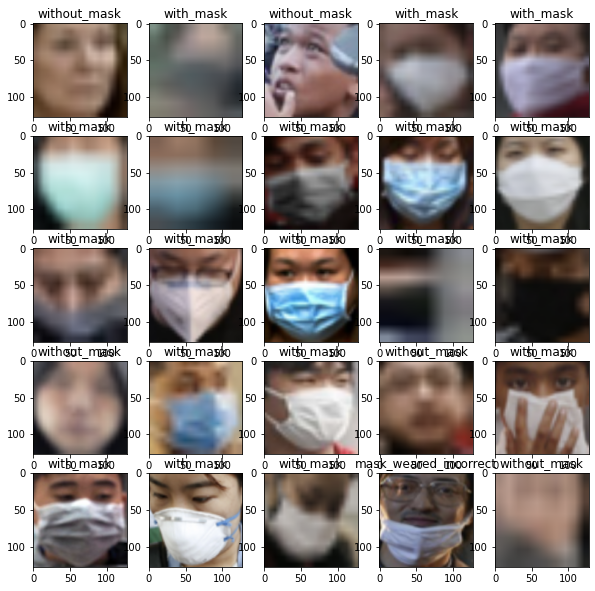

In [ ]:
#Check the total Images and label length are equal 
print(X.shape)
print(y.shape)


#Check random images 
fig,ax = plt.subplots(5,5)
fig.set_size_inches(10,10)

for i in range(5):
    for j in range(5):
        l = rn.randint(0,len(Labels))
        
        image = cv2.cvtColor(Image_array[l], cv2.COLOR_BGR2RGB)

        ax[i,j].imshow(image)
        ax[i,j].set_title(Labels[l])


In [ ]:
#Split the data for training and test        
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.20,random_state = 42)
#Check the total training images
print(X_train.shape)
print(y_train.shape)  

(3257, 128, 128, 3)
(3257, 3)


In [ ]:
# design model
model = Sequential()
model.add(Conv2D(filters = 64,kernel_size = (3,3),activation = 'relu',padding = 'same',input_shape = (Image_width,Image_height,3)))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())

model.add(Dense(90))

model.add(LeakyReLU(alpha=0.05))

model.add(Dense(3,activation = "softmax"))


Batch_size = 64
Epochs = 20
seed = 1000

In [ ]:
#Augmented Images
train_datagen = ImageDataGenerator(
                    rotation_range = 10,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    fill_mode = 'nearest')
#Callbacks
Estop = EarlyStopping(monitor = 'loss',patience = 2,verbose = 1,min_delta = 0.01)


In [ ]:

#Compile the model
model.compile(optimizer = Adam(lr = 0.001),loss = 'categorical_crossentropy',metrics = ['accuracy'])
model.summary()
history = model.fit(train_datagen.flow(X_train,y_train,batch_size = Batch_size),steps_per_epoch = X_train.shape[0]//Batch_size,epochs = Epochs,verbose=1,callbacks=[Estop])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 262144)            0         
_________________________________________________________________
dense_15 (Dense)             (None, 90)                23593050  
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 90)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 273       
Total params: 23,595,115
Trainable params: 23,595,115
Non-trainable params: 0
__________________________________________

#### ResNet

In [ ]:
from keras.applications import ResNet152V2

In [ ]:
base_model = ResNet152V2(weights= 'imagenet', include_top = False, input_shape = (Image_width,Image_height,3))

n_classes = 3
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [ ]:
keras.backend.clear_session()


In [ ]:

# model = keras.Sequential([
#     base_model,
#     layers.Flatten(),
#     layers.Dense(3, activation = 'softmax')
# ])

#optimizer = keras.optimizers.SGD(lr=0.01)
optimizer = keras.optimizers.SGD(lr=0.01, momentum = 0.9)
#optimizer = keras.optimizers.Adam(lr=0.01)
#optimizer = keras.optimizers.RMSprop(lr=0.01, rho=0.9)
#optimizer = keras.optimizers.Nadam(lr=0.01, beta_1=0.9, beta_2=0.999)

model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


Estop = EarlyStopping(monitor = 'loss',patience = 5,verbose = 1,min_delta = 0.01)


In [ ]:
Batch_size = 64
Epochs = 100
seed = 1000

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 66, 66, 64)   0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
history = model.fit(train_datagen.flow(X_train,y_train,batch_size = Batch_size),steps_per_epoch = X_train.shape[0]//Batch_size,epochs = Epochs,verbose=1,callbacks=[Estop])

Epoch 1/100
50/50 [==============================] - 31s 295ms/step - loss: 0.5089 - accuracy: 0.8266
Epoch 2/100
50/50 [==============================] - 15s 290ms/step - loss: 0.1888 - accuracy: 0.9347
Epoch 3/100
50/50 [==============================] - 15s 290ms/step - loss: 0.1335 - accuracy: 0.9582
Epoch 4/100
50/50 [==============================] - 15s 290ms/step - loss: 0.1239 - accuracy: 0.9595
Epoch 5/100
50/50 [==============================] - 15s 290ms/step - loss: 0.1088 - accuracy: 0.9627
Epoch 6/100
50/50 [==============================] - 15s 290ms/step - loss: 0.0859 - accuracy: 0.9688
Epoch 7/100
50/50 [==============================] - 15s 291ms/step - loss: 0.0763 - accuracy: 0.9773
Epoch 8/100
50/50 [==============================] - 15s 290ms/step - loss: 0.0656 - accuracy: 0.9776
Epoch 9/100
50/50 [==============================] - 15s 291ms/step - loss: 0.0522 - accuracy: 0.9809
Epoch 10/100
50/50 [==============================] - 15s 290ms/step - loss: 0.067

In [ ]:
model.evaluate(X_test, y_test)

26/26 [==============================] - 5s 60ms/step - loss: 0.1467 - accuracy: 0.9669


[0.14670082926750183, 0.9668711423873901]

In [ ]:
class_names = ["incorrect","mask","no_mask"]

In [ ]:
model_bu = model

Test on New Images

In [ ]:
import PIL
from PIL import Image

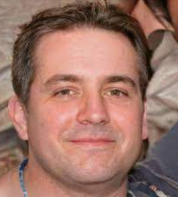

In [ ]:
Image.open('/content/gdrive/MyDrive/DL_Project/kaggle_pics/kaggle_api/generic.PNG')

In [ ]:
img = tf.io.read_file("/content/gdrive/MyDrive/DL_Project/kaggle_pics/kaggle_api/generic.PNG")

In [ ]:
img = tf.io.decode_image(img, channels=3)

In [ ]:
img = tf.image.resize(img, [128, 128])

In [ ]:
img = img/255.

In [ ]:
img.shape

TensorShape([128, 128, 3])

In [ ]:
img = np.expand_dims(img,axis=0)
print(img.shape)

(1, 128, 128, 3)


In [ ]:
pred = model.predict(img)

In [ ]:
print(pred)

[[3.2075323e-04 9.9937314e-01 3.0620210e-04]]


In [ ]:
class_names[tf.argmax(pred[0])]

'no_mask'

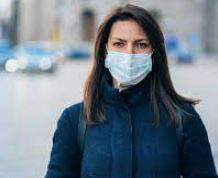

In [ ]:
Image.open('/content/gdrive/MyDrive/DL_Project/kaggle_pics/test_mask.JPEG')

In [ ]:
img2 = tf.io.read_file("/content/gdrive/MyDrive/DL_Project/kaggle_pics/test_mask.JPEG")

In [ ]:
img2 = tf.io.decode_image(img2, channels=3)

In [ ]:
img2 = tf.image.resize(img2, [128, 128])

In [ ]:
img2 = img2/255.

In [ ]:
img2 = np.expand_dims(img2,axis=0)
print(img2.shape)

(1, 128, 128, 3)


In [ ]:
pred =  model.predict(img2)

In [ ]:
print(pred)

[[2.0181353e-04 9.9926394e-01 5.3425459e-04]]


In [ ]:
class_names[tf.argmax(pred[0])]

'no_mask'

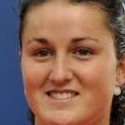

In [ ]:
Image.open('/content/gdrive/MyDrive/DL_Project/kaggle_pics/kaggle_api/Face Mask Dataset/Test/WithoutMask/4144.png')

In [ ]:
img3 =  tf.io.read_file("/content/gdrive/MyDrive/DL_Project/kaggle_pics/kaggle_api/Face Mask Dataset/Test/WithoutMask/4144.png")

In [ ]:
img3 = tf.io.decode_image(img3, channels=3)

In [ ]:
img3 = tf.image.resize(img3, [128, 128])

In [ ]:
img3 = img3/255.

In [ ]:
img3 = np.expand_dims(img3,axis=0)
print(img3.shape)

(1, 128, 128, 3)


In [ ]:
pred =  model.predict(img3)

In [ ]:
print(pred)

[[6.7514571e-07 9.6087521e-01 3.9124083e-02]]


In [ ]:
class_names[tf.argmax(pred[0])]

'no_mask'

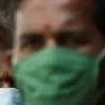

In [ ]:
Image.open('/content/gdrive/MyDrive/DL_Project/kaggle_pics/kaggle_api/Face Mask Dataset/Test/WithMask/84.png')

In [ ]:
img4 =  tf.io.read_file("/content/gdrive/MyDrive/DL_Project/kaggle_pics/kaggle_api/Face Mask Dataset/Test/WithMask/84.png")

In [ ]:
img4 = tf.io.decode_image(img4, channels=3)

In [ ]:
img4 = tf.image.resize(img4, [128, 128])

In [ ]:
img4 = img4/255.

In [ ]:
img4 = np.expand_dims(img4,axis=0)
print(img4.shape)

(1, 128, 128, 3)


In [ ]:
pred =  model.predict(img4)

In [ ]:
print(pred)

[[2.161688e-06 9.999975e-01 3.385763e-07]]


In [ ]:
class_names[tf.argmax(pred[0])]

'no_mask'

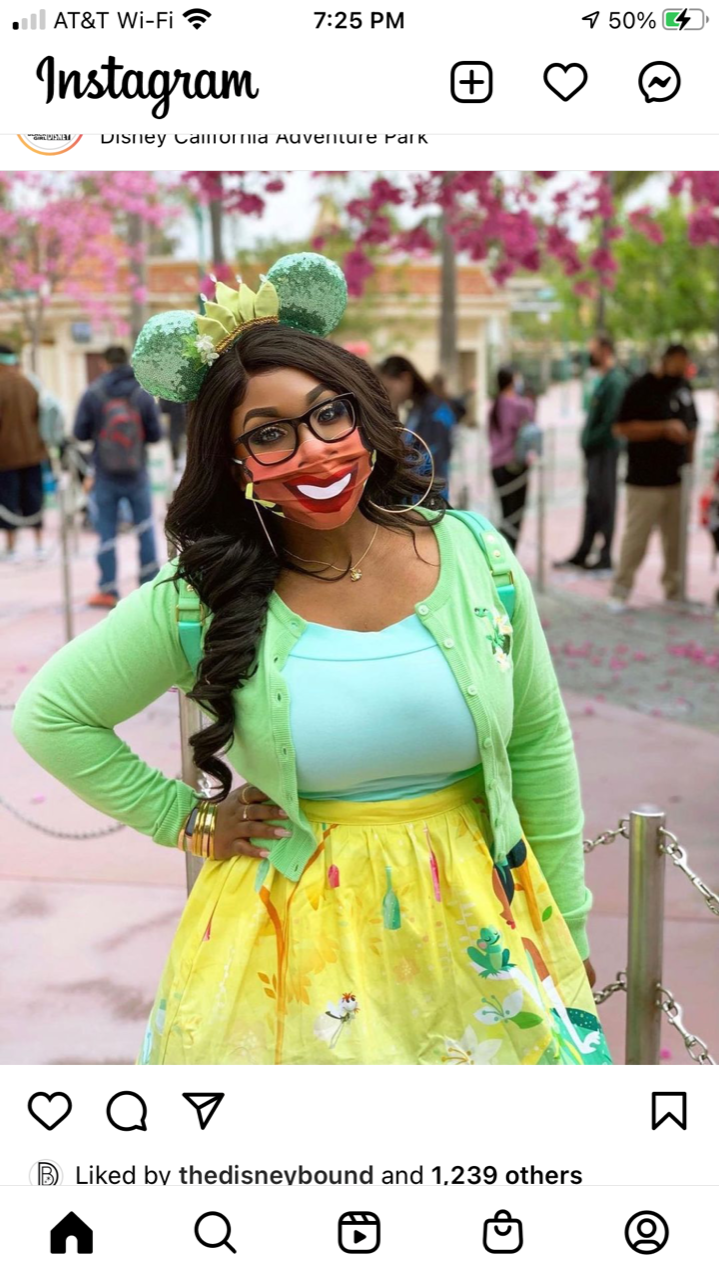

In [ ]:
Image.open('/content/gdrive/MyDrive/DL_Project/kaggle_pics/email.png')

In [ ]:
img5 =  tf.io.read_file("/content/gdrive/MyDrive/DL_Project/kaggle_pics/email.png")

In [ ]:
img5 = tf.io.decode_image(img5, channels=3)

In [ ]:
img5 = tf.image.resize(img5, [128, 128])

In [ ]:
img5 = img5/255.

In [ ]:
img5 = np.expand_dims(img5,axis=0)
print(img5.shape)

(1, 128, 128, 3)


In [ ]:
pred =  model.predict(img5)

In [ ]:
print(pred)

[[8.2055667e-05 9.9990737e-01 1.0654057e-05]]


In [ ]:
class_names[tf.argmax(pred[0])]

'no_mask'

# AlexNet

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(128,128,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')])

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=0.01), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 384)         8

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

In [ ]:
Estop = EarlyStopping(monitor = 'loss',patience = 5,verbose = 1,min_delta = 0.01)

In [ ]:
model.fit(train_datagen.flow(X_train,y_train,batch_size = Batch_size),steps_per_epoch = X_train.shape[0]//Batch_size,epochs = Epochs,verbose=1,callbacks=[Estop])

Epoch 1/100
50/50 [==============================] - 13s 240ms/step - loss: 0.8394 - accuracy: 0.7949
Epoch 2/100
50/50 [==============================] - 12s 246ms/step - loss: 0.3183 - accuracy: 0.9018
Epoch 3/100
50/50 [==============================] - 12s 242ms/step - loss: 0.2999 - accuracy: 0.9025
Epoch 4/100
50/50 [==============================] - 12s 240ms/step - loss: 0.2918 - accuracy: 0.9173
Epoch 5/100
50/50 [==============================] - 12s 240ms/step - loss: 0.2898 - accuracy: 0.9106
Epoch 6/100
50/50 [==============================] - 12s 239ms/step - loss: 0.2727 - accuracy: 0.9165
Epoch 7/100
50/50 [==============================] - 12s 242ms/step - loss: 0.2614 - accuracy: 0.9209
Epoch 8/100
50/50 [==============================] - 12s 239ms/step - loss: 0.2645 - accuracy: 0.9169
Epoch 9/100
50/50 [==============================] - 12s 241ms/step - loss: 0.2292 - accuracy: 0.9288
Epoch 10/100
50/50 [==============================] - 12s 241ms/step - loss: 0.251

In [ ]:
model.evaluate(X_test, y_test)

26/26 [==============================] - 0s 7ms/step - loss: 0.1982 - accuracy: 0.9264


[0.1982324719429016, 0.9263803958892822]

In [ ]:
model_bu = model

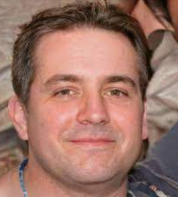

In [ ]:
Image.open('/content/gdrive/MyDrive/DL_Project/kaggle_pics/kaggle_api/generic.PNG')

In [ ]:
img = tf.io.read_file("/content/gdrive/MyDrive/DL_Project/kaggle_pics/kaggle_api/generic.PNG")

In [ ]:
img = tf.io.decode_image(img, channels=3)

In [ ]:
img = tf.image.resize(img, [128, 128])

In [ ]:
img = img/255.

In [ ]:
img.shape

TensorShape([128, 128, 3])

In [ ]:
img = np.expand_dims(img,axis=0)
print(img.shape)

(1, 128, 128, 3)


In [ ]:
pred = model.predict(img)

In [ ]:
print(pred)

[[6.839950e-04 9.992446e-01 7.150962e-05]]


In [ ]:
class_names[tf.argmax(pred[0])]

'no_mask'

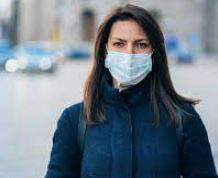

In [ ]:
Image.open('/content/gdrive/MyDrive/DL_Project/kaggle_pics/test_mask.JPEG')

In [ ]:
img2 = tf.io.read_file("/content/gdrive/MyDrive/DL_Project/kaggle_pics/test_mask.JPEG")

In [ ]:
img2 = tf.io.decode_image(img2, channels=3)

In [ ]:
img2 = tf.image.resize(img2, [128, 128])

In [ ]:
img2 = img2/255.

In [ ]:
img2 = np.expand_dims(img2,axis=0)
print(img2.shape)

(1, 128, 128, 3)


In [ ]:
pred =  model.predict(img2)

In [ ]:
print(pred)

[[0.10839757 0.69094306 0.20065938]]


In [ ]:
class_names[tf.argmax(pred[0])]

'no_mask'

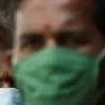

In [ ]:
Image.open('/content/gdrive/MyDrive/DL_Project/kaggle_pics/kaggle_api/Face Mask Dataset/Test/WithMask/84.png')

In [ ]:
img4 =  tf.io.read_file("/content/gdrive/MyDrive/DL_Project/kaggle_pics/kaggle_api/Face Mask Dataset/Test/WithMask/84.png")

In [ ]:
img4 = tf.io.decode_image(img4, channels=3)

In [ ]:
img4 = tf.image.resize(img4, [128, 128])

In [ ]:
img4 = img4/255.

In [ ]:
img4 = np.expand_dims(img4,axis=0)
print(img4.shape)

(1, 128, 128, 3)


In [ ]:
pred =  model.predict(img4)

In [ ]:
print(pred)

[[0.0391566  0.94948757 0.01135578]]


In [ ]:
class_names[tf.argmax(pred[0])]

'no_mask'